In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu

In [2]:
outdir    = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"

In [3]:
outfigdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/241209"
!mkdir -p $outfigdir
fig_manager = powerplots.FigManager(outfigdir)

/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/241209


In [4]:
%%time
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR','P38NR','P38DR','P28DL'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

CPU times: user 875 ms, sys: 3.58 s, total: 4.45 s
Wall time: 33.3 s


View of AnnData object with n_obs × n_vars = 21269 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)

# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

/tmp/ipykernel_4308/968974219.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


In [6]:
agenes = df[df['P17on']=='A']['gene'].values
bgenes = df[df['P17on']=='B']['gene'].values
cgenes = df[df['P17on']=='C']['gene'].values

print(len(agenes), len(bgenes), len(cgenes), len(agenes)+len(bgenes)+len(cgenes))

122 35 129 286


In [7]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

# get biosample
adata_raw.obs['biosample'] = adata_raw.obs['sample'].apply(lambda x: x[:-1])


# easitype
rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}
def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

# record
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values


/tmp/ipykernel_4308/3389865497.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [8]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

# select genes
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

adata = adata_sub[:,l23_gidx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 21269 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'biosample', 'easitype'
    layers: 'norm', 'lognorm'

# PCA - AA

In [9]:
from py_pcha import PCHA

In [10]:
def pca_pipe(adata):
    
    np.random.seed(0)
    pca = PCA(n_components=4)
    
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    # zlognorm = np.nan_to_num(zlognorm, 0)
    
    pcs = pca.fit_transform(zlognorm) # auto centering
    
    return zlognorm-np.mean(zlognorm, axis=0), pca, pcs # manual centering

In [11]:
def get_dists_to_specialists(prj, XC):
    """
    """
    diffs = np.array([prj-XC[:,0], prj-XC[:,1], prj-XC[:,2]]) # specialist by cell by dim
    dists = np.sqrt(np.sum(np.power(diffs, 2), axis=2)) # specialist by cell
    # print(diffs.shape, dists.shape)
    return dists

In [12]:
def aa_inference(X):
    """
    """
    XC, _, _, _, _ = PCHA(X, noc=3, delta=0)
    XC = np.array(XC)
    XC = XC[:,np.argsort(XC[0])] # assign an order according to x-axis 
    return XC

In [13]:
def add_triangle(XC, ax, zorder=0, vertices=False, label='', linecolor='gray', linewidth=1, alpha=1, **kwargs):
    # add the triangle
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--', 
            color=linecolor, label=label, zorder=zorder, linewidth=linewidth, markersize=3, alpha=alpha)
    
    # add vertices
    if vertices:
        ax.scatter(XC[0,0], XC[1,0], color='C0', zorder=zorder, alpha=alpha, **kwargs)
        ax.scatter(XC[0,1], XC[1,1], color='C1', zorder=zorder, alpha=alpha, **kwargs)
        ax.scatter(XC[0,2], XC[1,2], color='C2', zorder=zorder, alpha=alpha, **kwargs)

In [14]:
def neighbor_label_transfer(k, ref_emb, qry_emb, ref_lbl, p_cutoff=0.5, dist_cutoff=None):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(ref_emb)
    dists, idx = neigh.kneighbors(qry_emb, k, return_distance=True)
    
    raw_pred = ref_lbl[idx]

    # p
    pabc = np.empty((qry_n, n_unq_lbls))
    for i, lbl in enumerate(unq_lbls):
        p = np.sum(raw_pred==lbl, axis=1)/k
        pabc[:,i] = p

    # max
    max_pred = unq_lbls[np.argmax(pabc, axis=1)]

    # 
    gated_pred = max_pred.copy()
    cond1 = np.max( pabc, axis=1) > p_cutoff
    gated_pred[~cond1] = 'NA' 
    if dist_cutoff is not None:
        cond2 = np.max(dists, axis=1) < dist_cutoff
        gated_pred[~cond2] = 'NA' 
    
    return max_pred, gated_pred, np.max(dists, axis=1)


def neighbor_self_nonself(k, ref_emb, qry_emb):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    lbls = np.array([0]*ref_n+[1]*qry_n)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(np.vstack([ref_emb, qry_emb]))
    idx = neigh.kneighbors(qry_emb, k, return_distance=False)
    
    isself = lbls[idx]

    p = np.sum(isself, axis=1)/k

    
    return p # max_pred, gated_pred, np.max(dists, axis=1)

In [15]:
np.random.seed(0)

X, pca, pcs = pca_pipe(adata)
V = pca.components_.T
V[:,1] = -V[:,1]
pcs[:,1] = -pcs[:,1]

In [16]:
# X, pca, pcs = pca_pipe(adata[adata.obs['cond']=='P28NR'])
# V = pca.components_.T
# V[:,1] = -V[:,1]
# zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
# zlognorm = np.nan_to_num(zlognorm, 0)
# pcs = pca.fit_transform(zlognorm)
# # pcs[:,1] = -pcs[:,1]


In [17]:
adata.obsm['pcs'] = pcs
adata.obs['PC1']  = pcs[:,0]
adata.obs['PC2']  = pcs[:,1]

In [18]:
adata_nr = adata[adata.obs['cond'].isin(['P28NR', 'P38NR'])]
adata_dr = adata[adata.obs['cond'].isin(['P28DR', 'P38DR'])]
adata_dl = adata[adata.obs['cond'].isin(['P28DL'])]

adata_nr28 = adata[adata.obs['cond']=='P28NR']
adata_nr38 = adata[adata.obs['cond']=='P38NR']

adata_dr28 = adata[adata.obs['cond']=='P28DR']
adata_dr38 = adata[adata.obs['cond']=='P38DR']

adata_dl28 = adata[adata.obs['cond']=='P28DL']

adata_nr28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_1' in x)]
adata_nr28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_2' in x)]

adata_nr38_1 = adata[adata.obs['sample'].apply(lambda x: 'P38_1' in x)]
adata_nr38_2 = adata[adata.obs['sample'].apply(lambda x: 'P38_2' in x)]

adata_dr28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_dr_1' in x)]
adata_dr28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_dr_3' in x)]

adata_dr38_1 = adata[adata.obs['sample'].apply(lambda x: 'P38_dr_1' in x)]
adata_dr38_2 = adata[adata.obs['sample'].apply(lambda x: 'P38_dr_2' in x)]

adata_dl28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_dl_1' in x)]
adata_dl28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_dl_2' in x)]

In [19]:
adata_dict = {
    'P28NR': adata_nr28, 
    'P38NR': adata_nr38, 
    
    'P28DR': adata_dr28, 
    'P38DR': adata_dr38, 
    
    'P28DL': adata_dl28, 
    
    'P28NR_1': adata_nr28_1, 
    'P28NR_2': adata_nr28_2, 
    'P38NR_1': adata_nr38_1, 
    'P38NR_2': adata_nr38_2, 
    
    'P28DR_1': adata_dr28_1, 
    'P28DR_2': adata_dr28_2, 
    'P38DR_1': adata_dr38_1, 
    'P38DR_2': adata_dr38_2, 
    
    'P28DL_1': adata_dl28_1, 
    'P28DL_2': adata_dl28_2, 
    
    'NR': adata_nr, 
    'DR': adata_dr, 
    'DL': adata_dl, 
}

In [20]:
palette_type = collections.OrderedDict({
    "L2/3_A": "C0",
    "L2/3_B": "C1",
    "L2/3_C": "C2",
})
palette_type_list = [c for i, c in palette_type.items()]

In [21]:
labels = ['P28NR', 'P38NR', 'P28DR', 'P38DR', 'P28DL']

labels_p = ['P28NR_1', 'P28NR_2', 'P38NR_1', 'P38NR_2', 
            'P28DR_1', 'P28DR_2', 'P38DR_1', 'P38DR_2', 
            'P28DL_1', 'P28DL_2',]

labels_m = ['NR', 'DR', 'DL'] 
labels_m2 = ['P28NR', 'P28DR', 'P28DL'] 

# Archetype location

In [22]:
np.random.seed(0)

XC_dict = {}
for lbl in labels: 
    adatasub = adata_dict[lbl]
    X = adatasub.obsm['pcs'][:,:2].T
    XC = aa_inference(X)
    XC_dict[lbl] = XC
    
for lbl in labels_p: 
    adatasub = adata_dict[lbl]
    X = adatasub.obsm['pcs'][:,:2].T
    XC = aa_inference(X)
    XC_dict[lbl] = XC
    
for lbl in labels_m: 
    adatasub = adata_dict[lbl]
    X = adatasub.obsm['pcs'][:,:2].T
    XC = aa_inference(X)
    XC_dict[lbl] = XC

In [23]:
XC_dict

{'P28NR': array([[-13.81741959,   0.2069535 ,  15.52513499],
        [  6.22002152,  -9.81653214,   6.60634076]]),
 'P38NR': array([[-14.92839386,   0.03556488,  14.00828275],
        [  6.56510213,  -9.17338943,   6.80540275]]),
 'P28DR': array([[-13.7958107 ,   0.56326285,  12.32185833],
        [  7.50200987,  -9.26467436,   6.64305032]]),
 'P38DR': array([[-13.03489808,   0.20769304,  13.54844327],
        [  7.03705692, -10.96055031,   5.56319058]]),
 'P28DL': array([[-14.11065483,   0.48472336,  15.85899954],
        [  7.23767138, -11.73415947,   3.80554281]]),
 'P28NR_1': array([[-13.75190449,   0.2069535 ,  15.2597411 ],
        [  6.47938824,  -9.81653214,   6.8351922 ]]),
 'P28NR_2': array([[-13.78515096,   0.02462905,  15.60511684],
        [  5.88061211,  -8.80943617,   6.40848207]]),
 'P38NR_1': array([[-13.17131233,   0.03556488,  14.11905013],
        [  4.94842386,  -9.17338943,   6.44850849]]),
 'P38NR_2': array([[-15.08403178,   0.45165956,  13.8370018 ],
        [  

In [24]:
# dists_dict = {}
# dists_dict2 = {}
# for lbl in labels: 
#     adatasub = adata_dict[lbl]
#     prj = adatasub.obsm['pcs'][:,:2]
    
#     # local
#     XC  = XC_dict[lbl]
#     dists = get_dists_to_specialists(prj, XC)
#     dists_dict[lbl] = dists
    
#     # global
#     XC  = XC_dict['P28NR']
#     dists = get_dists_to_specialists(prj, XC)
#     dists_dict2[lbl] = dists

In [25]:
color_dict = {
    'P28NR': 'C1', 
    'P38NR': 'C1', 
    
    'P28DR': 'k',
    'P38DR': 'k',
    
    'P28DL': 'C3',
}

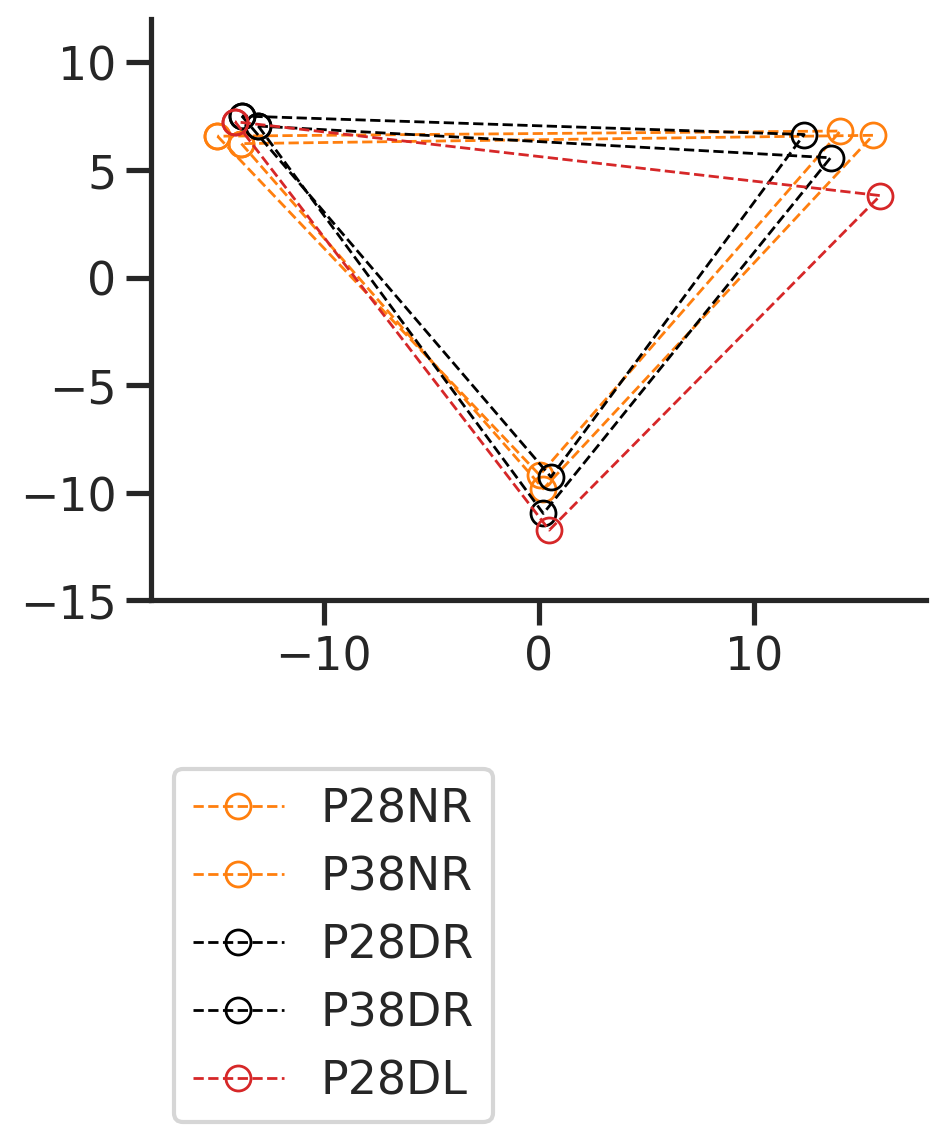

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5*1,1*4)) # , sharex=True, sharey=True)
for lbl in labels:
    XC = XC_dict[lbl]
    color = color_dict[lbl]
    
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--o', fillstyle='none', label=lbl, color=color, linewidth=1)
    ax.legend(bbox_to_anchor=(0,-0.25), loc='upper left')
    ax.set_aspect('equal')
    ax.grid(False)
    sns.despine(ax=ax)
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])

# output = os.path.join(outfigdir, 'aa0.pdf')
# powerplots.savefig_autodate(fig, output)
plt.show()

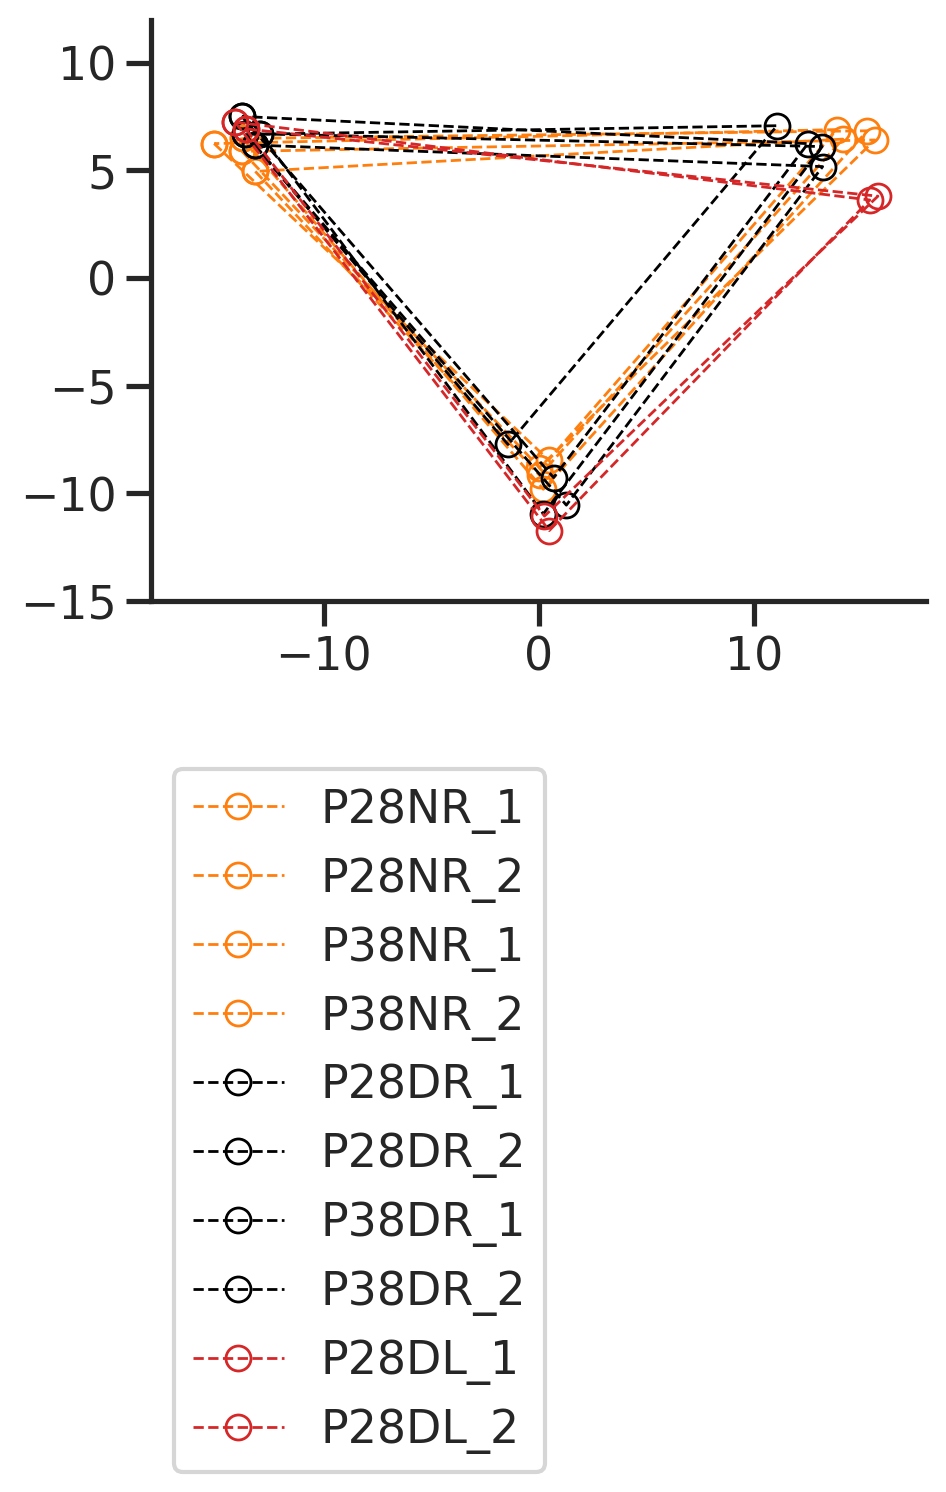

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5*1,1*4)) # , sharex=True, sharey=True)
for lbl in labels_p:
    XC = XC_dict[lbl]
    color = color_dict[lbl[:5]]
    
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--o', fillstyle='none', label=lbl, color=color, linewidth=1)
    ax.legend(bbox_to_anchor=(0,-0.25), loc='upper left')
    ax.set_aspect('equal')
    ax.grid(False)
    sns.despine(ax=ax)
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])

# output = os.path.join(outfigdir, 'aa_1.pdf')
# powerplots.savefig_autodate(fig, output)
plt.show()

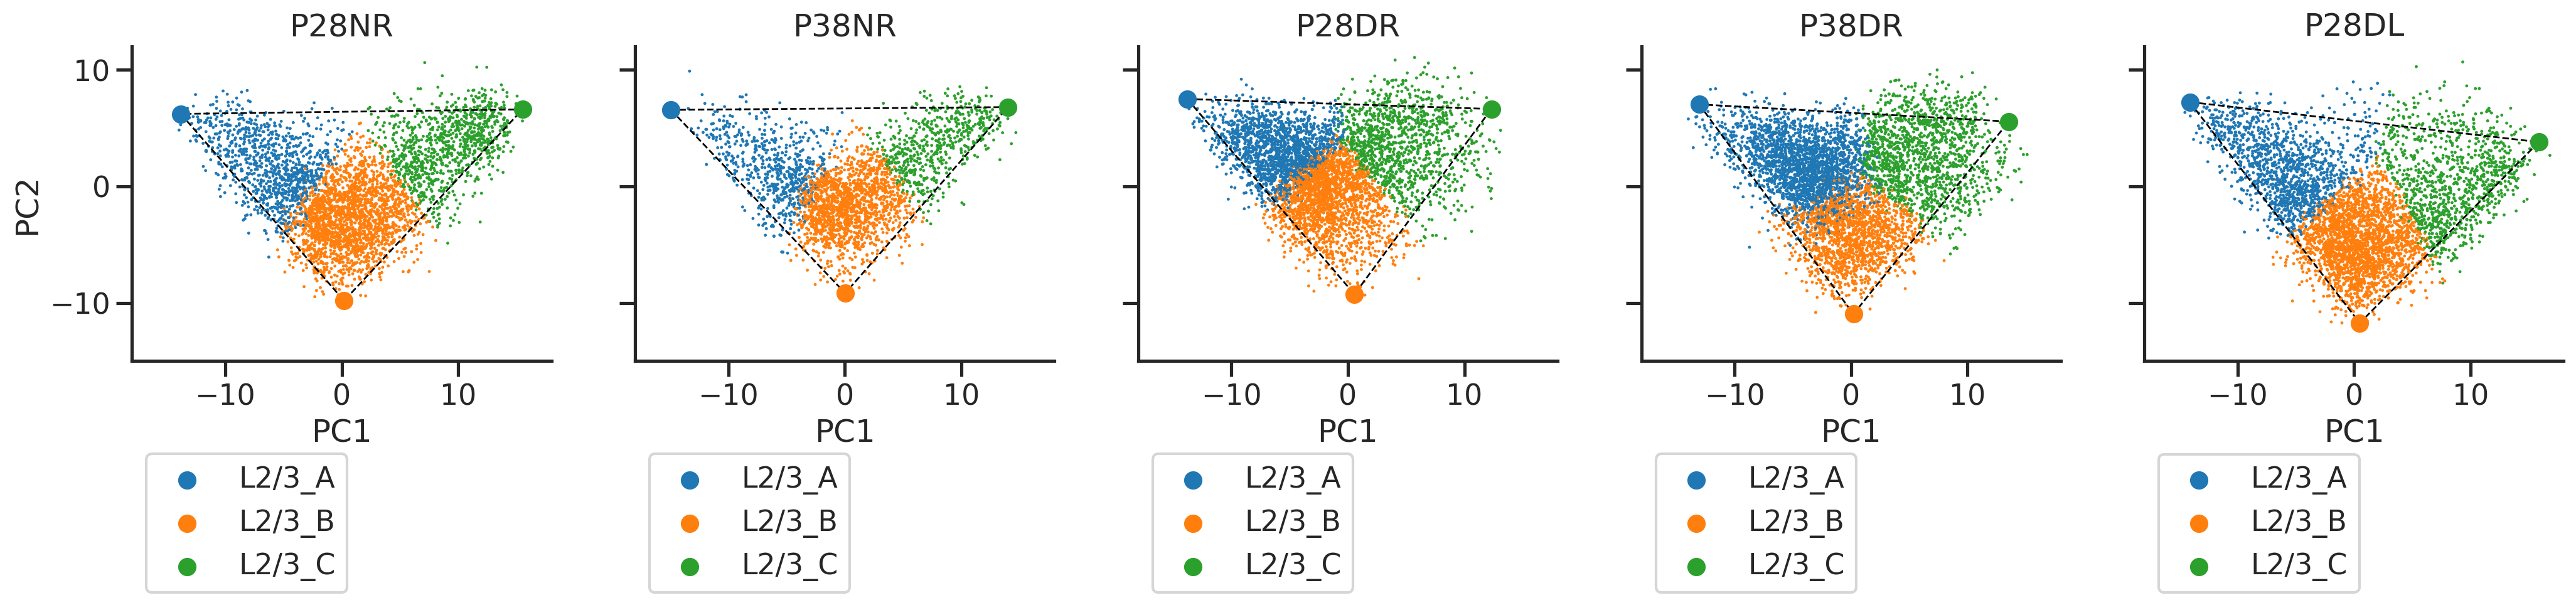

In [28]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, lbl in zip(axs, labels):
    XC = XC_dict[lbl]
    adatasub = adata_dict[lbl]
    sns.scatterplot(data=adatasub.obs, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), 
                    rasterized=True,
                    ax=ax)
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.legend(bbox_to_anchor=(0,-0.25), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')
    ax.grid(False)
    sns.despine(ax=ax)
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])

# output = os.path.join(outfigdir, 'aa_2.pdf')
# powerplots.savefig_autodate(fig, output)
plt.show()

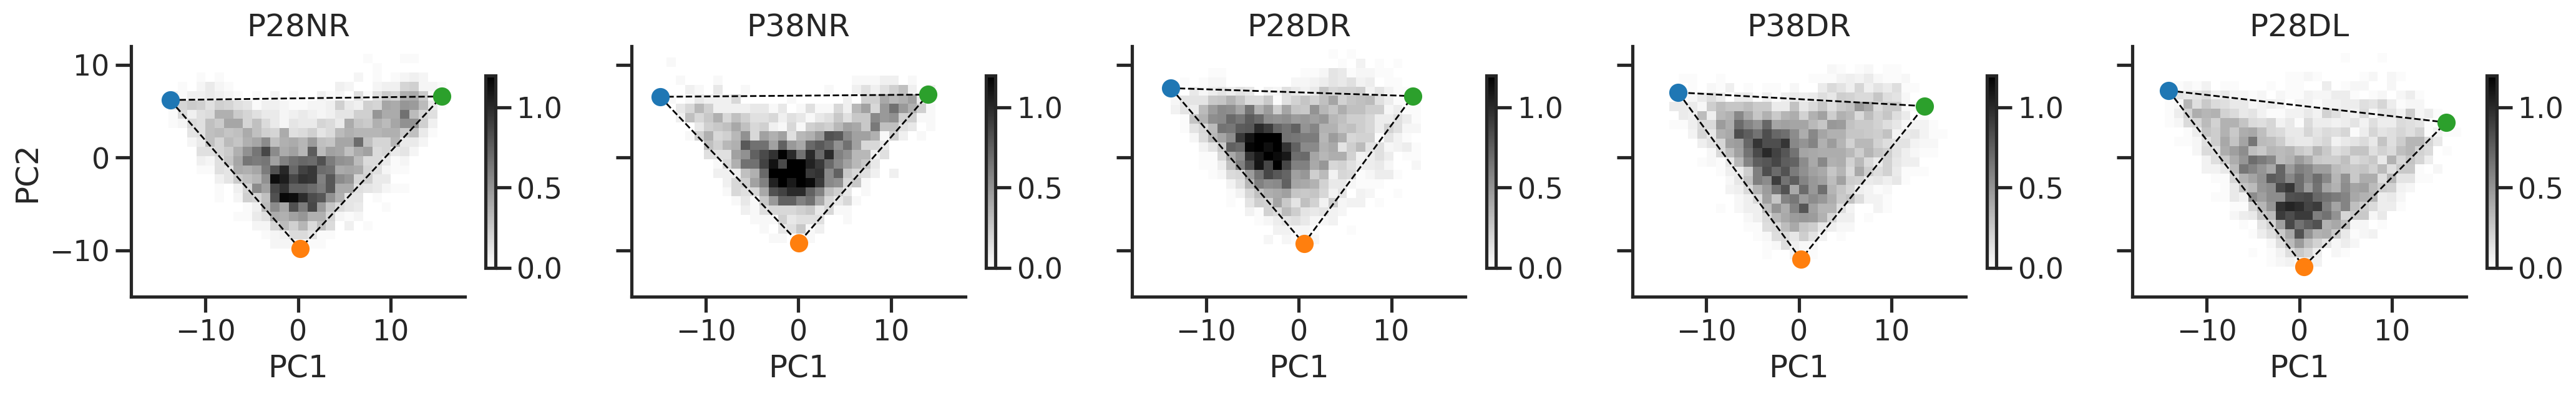

In [29]:
fig, axs = plt.subplots(1, 5, figsize=(5*5,1*4), sharex=True, sharey=True)
for ax, lbl in zip(axs, labels):
    XC = XC_dict[lbl]
    adatasub = adata_dict[lbl]
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1, vmin=0, vmax=1.2,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl)
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
# output = os.path.join(outfigdir, 'aa3.pdf')
# powerplots.savefig_autodate(fig, output)
plt.show()

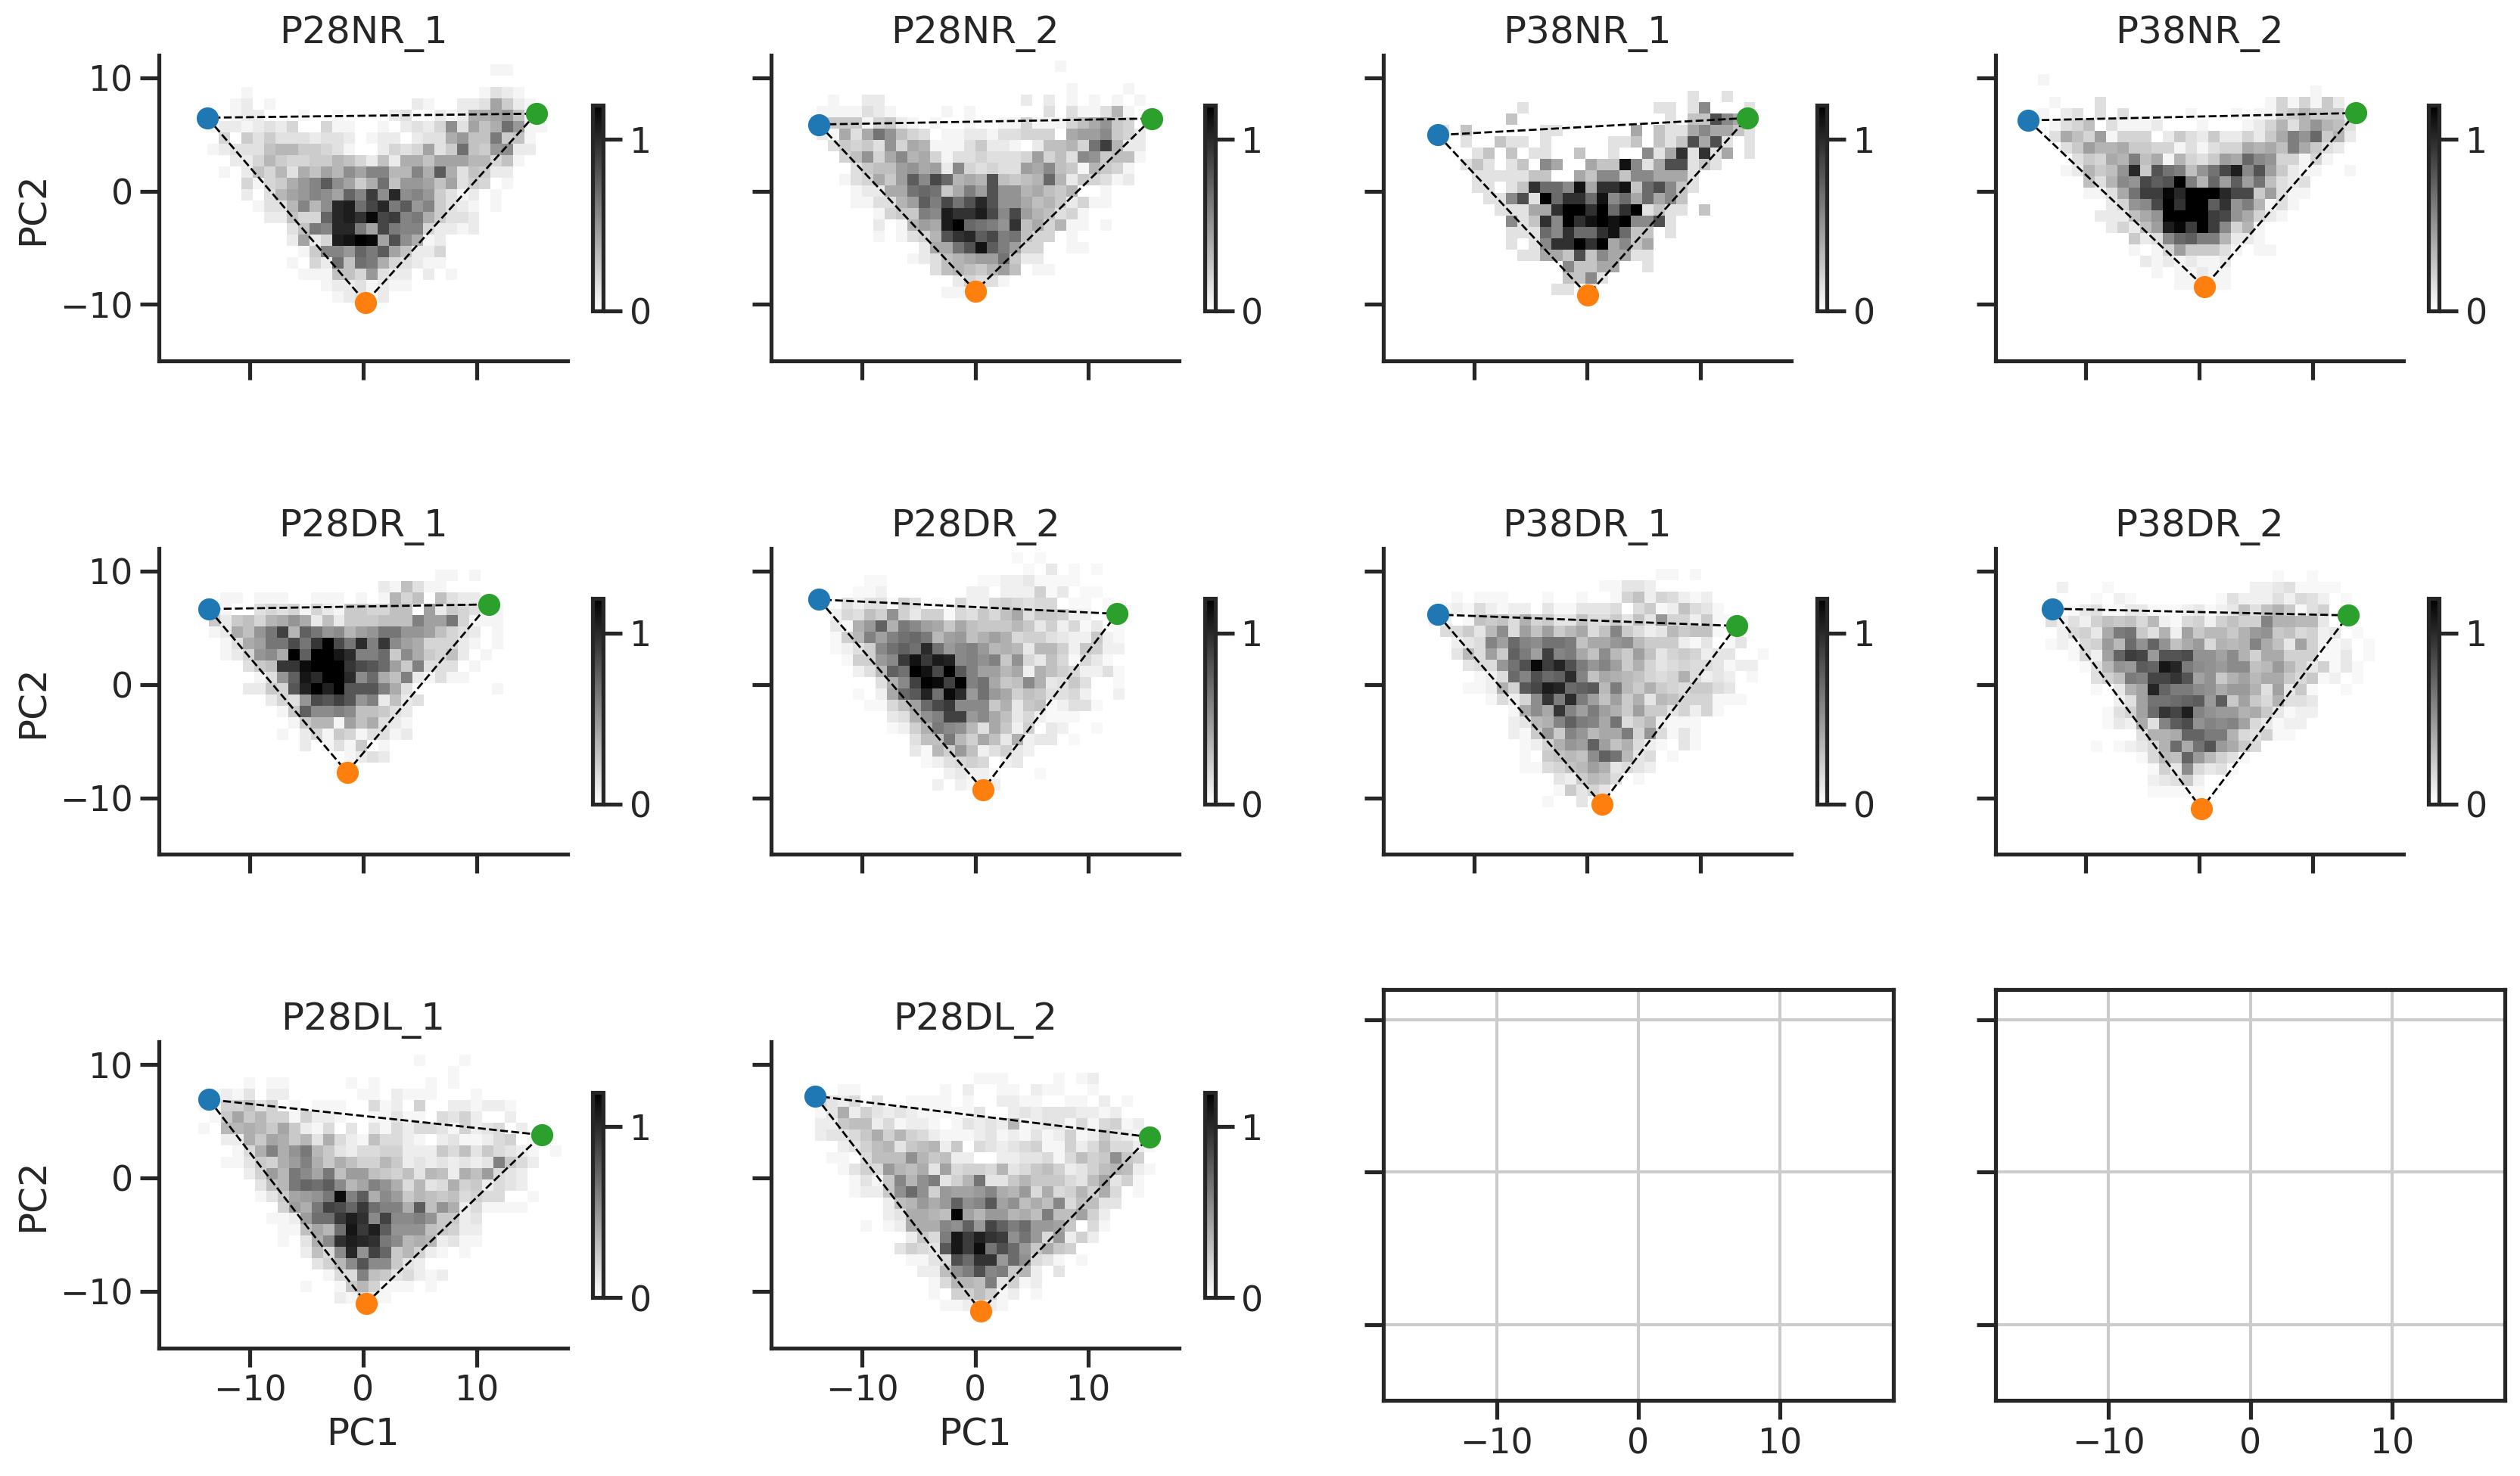

In [30]:
fig, axs = plt.subplots(3, 4, figsize=(5*4,3*4), sharex=True, sharey=True)
for ax, lbl in zip(axs.flat, labels_p):
    XC = XC_dict[lbl]
    adatasub = adata_dict[lbl]
    n = len(adatasub)
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1, vmin=0, vmax=1.2,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl) # +f'\n{n} cells')
    # ax.set_title(lbl+f'\n{n} cells')
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
# output = os.path.join(outfigdir, 'aa_4.pdf')
# powerplots.savefig_autodate(fig, output)
plt.show()

# fix a common one

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/241209/type_abc_triangles_drdl_2024-12-09.pdf


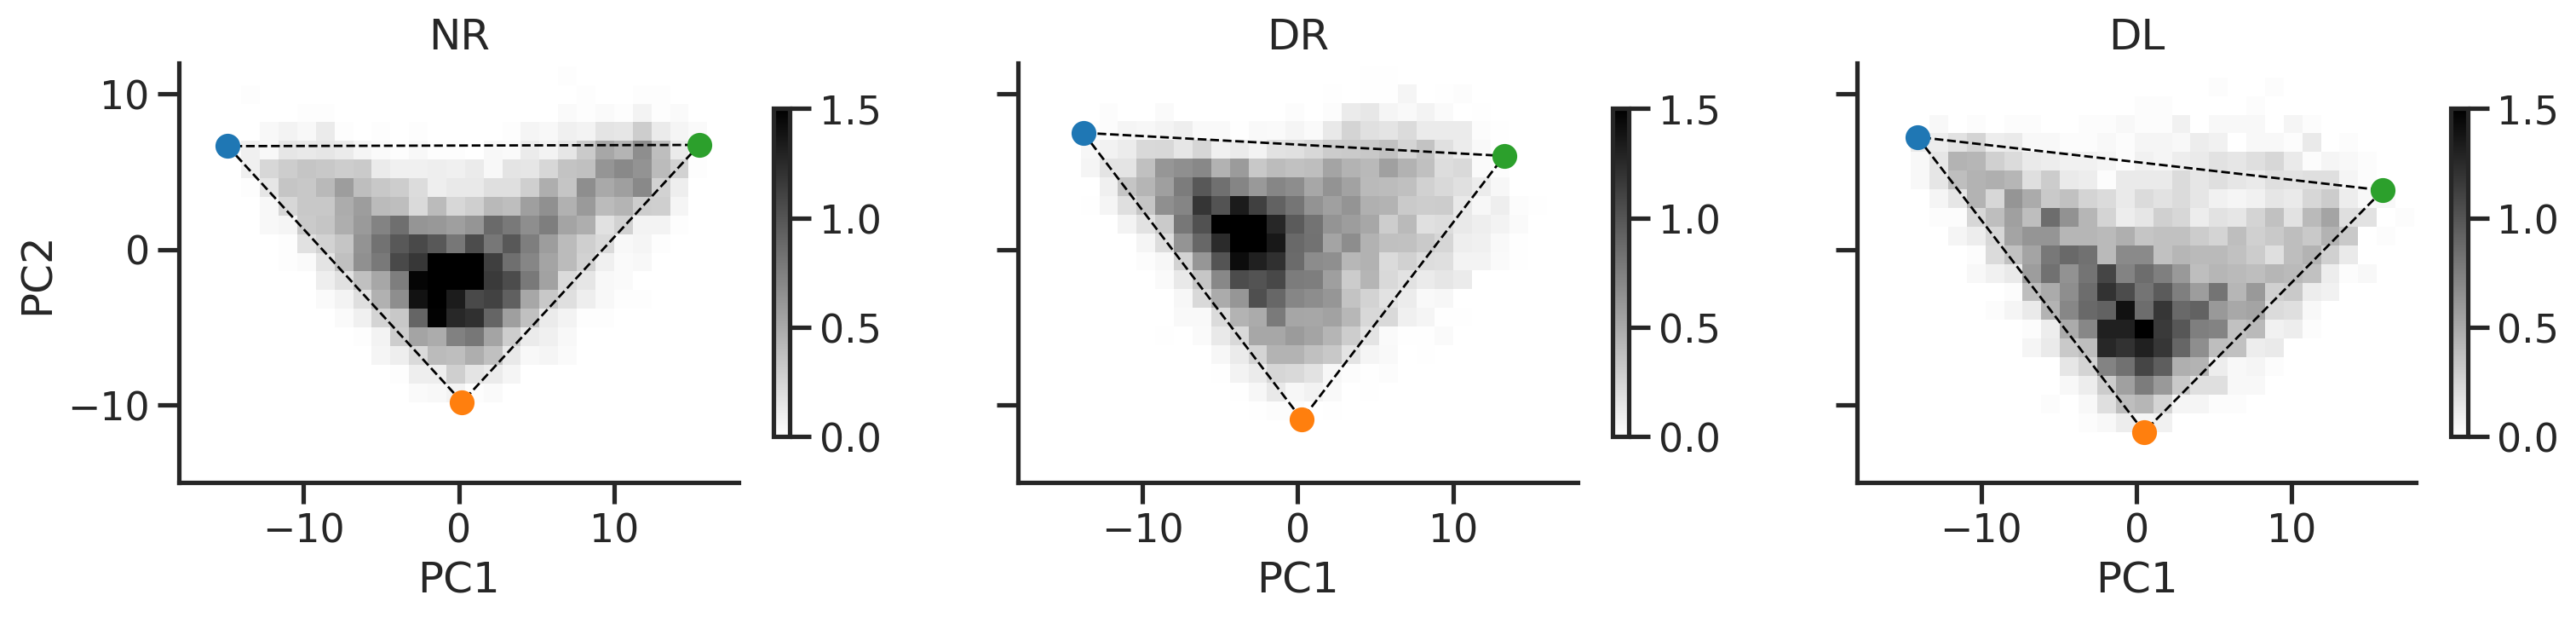

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(6*3,5*1), sharex=True, sharey=True)
XC = XC_dict['NR']
for ax, lbl in zip(axs.flat, labels_m):
    XC = XC_dict[lbl]
    adatasub = adata_dict[lbl]
    n = len(adatasub)
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1.2, vmin=0, vmax=1.5,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl) # +f'\n{n} cells')
    # ax.set_title(lbl+f'\n{n} cells')
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
output = os.path.join(outfigdir, "type_abc_triangles_drdl.pdf")
powerplots.savefig_autodate(fig, output)
plt.show()

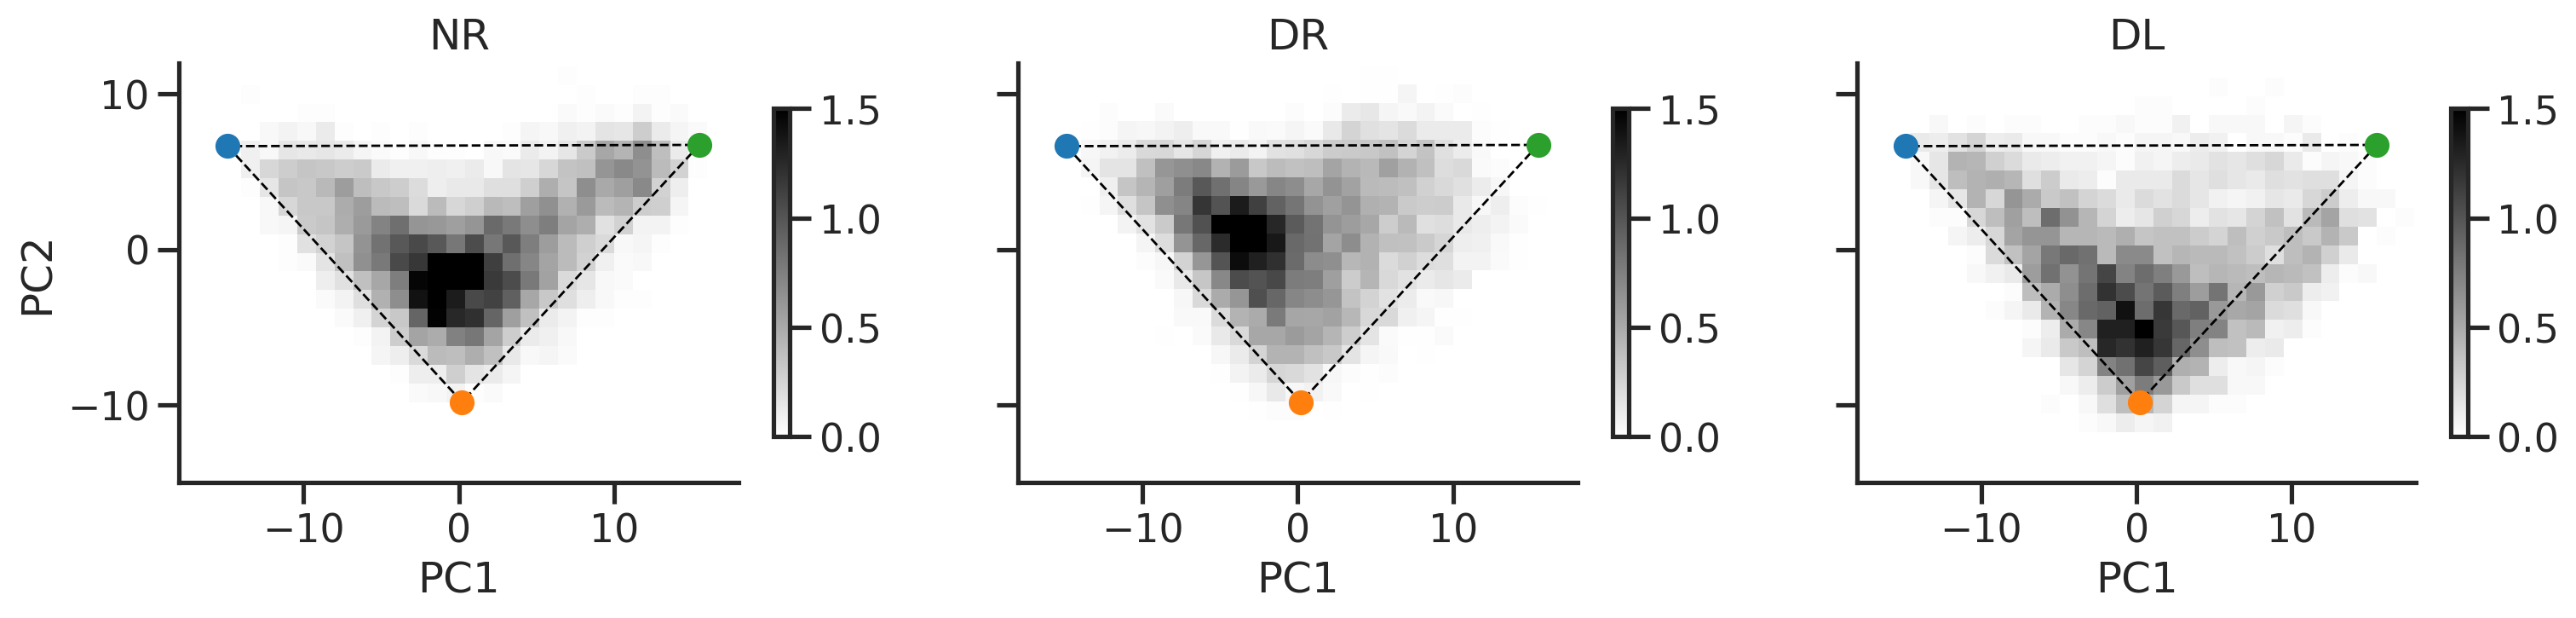

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(6*3,5*1), sharex=True, sharey=True)
XC = XC_dict['NR']
for ax, lbl in zip(axs.flat, labels_m):
    # XC = XC_dict[lbl]
    adatasub = adata_dict[lbl]
    n = len(adatasub)
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1.2, vmin=0, vmax=1.5,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl) # +f'\n{n} cells')
    # ax.set_title(lbl+f'\n{n} cells')
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
# output = os.path.join(outfigdir, 'aa5.pdf')
# powerplots.savefig_autodate(fig, output)
plt.show()

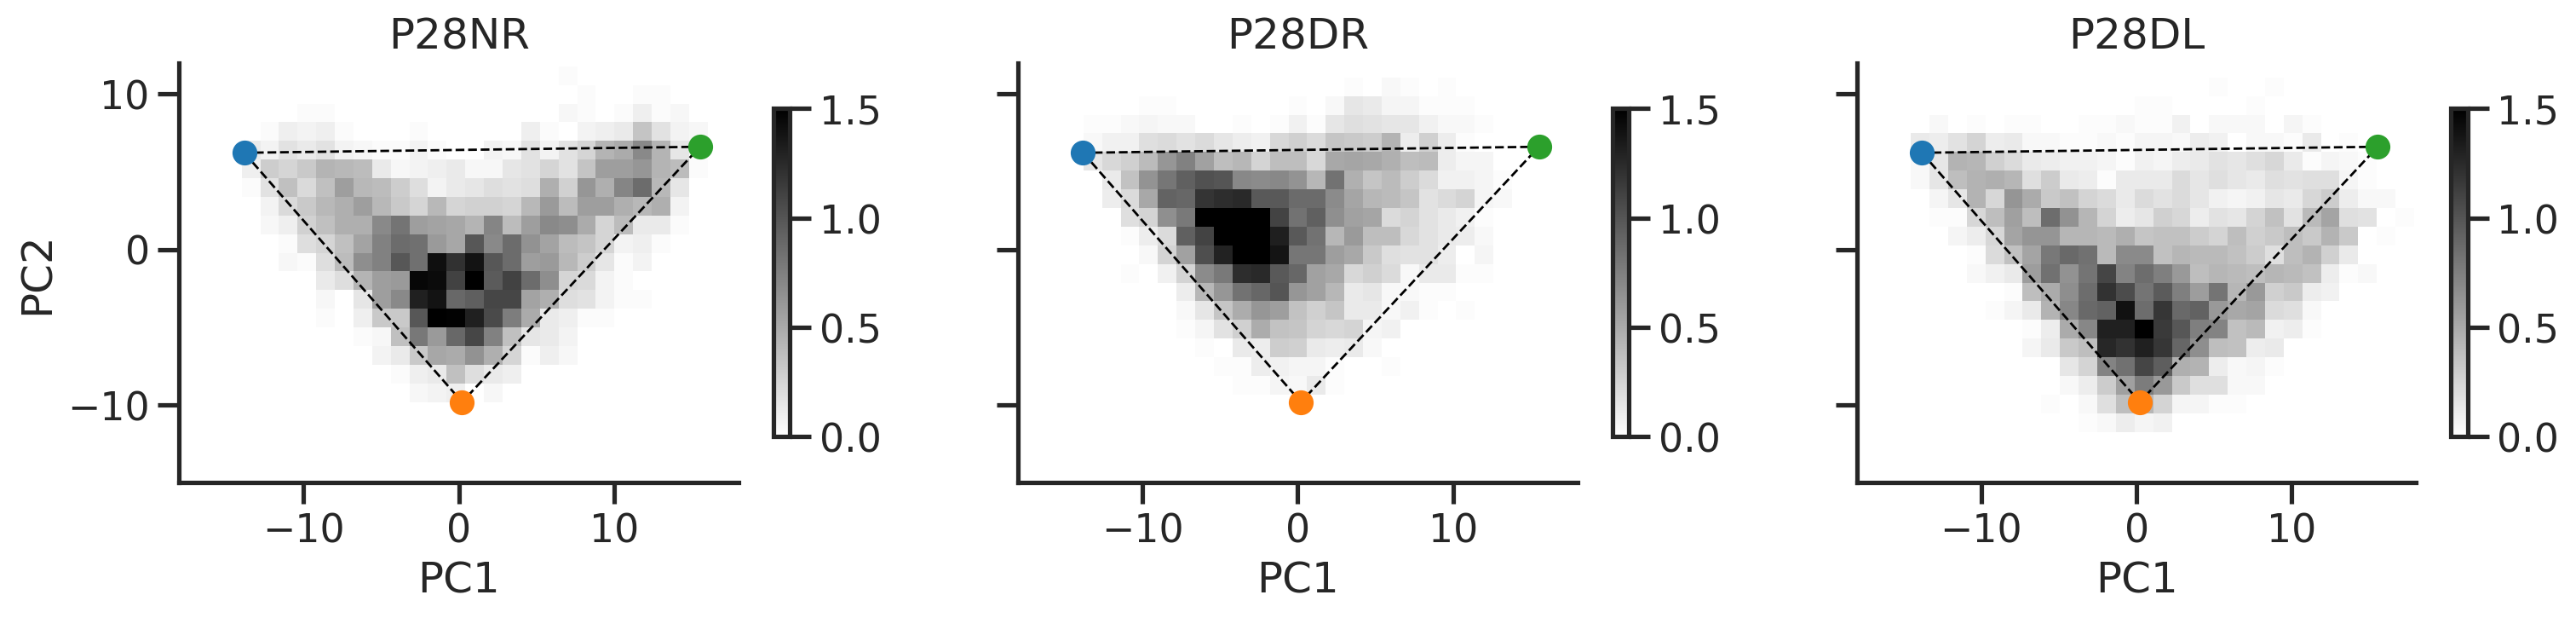

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(6*3,5*1), sharex=True, sharey=True)
XC = XC_dict['P28NR']
for ax, lbl in zip(axs.flat, labels_m2):
    adatasub = adata_dict[lbl]
    n = len(adatasub)
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1.2, vmin=0, vmax=1.5,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl) # +f'\n{n} cells')
    # ax.set_title(lbl+f'\n{n} cells')
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
# output = os.path.join(outfigdir, 'aa5.pdf')
# powerplots.savefig_autodate(fig, output)
plt.show()

# quantification

In [34]:
def p_mark(p):
    """
    """
    
    if p > 0.05:
        mark = 'ns'
    elif p < 0.05 and p > 0.001:
        mark = '*'
    elif p < 0.001:
        mark = '***'
        
    return mark

In [35]:
XC_dict.keys()

dict_keys(['P28NR', 'P38NR', 'P28DR', 'P38DR', 'P28DL', 'P28NR_1', 'P28NR_2', 'P38NR_1', 'P38NR_2', 'P28DR_1', 'P28DR_2', 'P38DR_1', 'P38DR_2', 'P28DL_1', 'P28DL_2', 'NR', 'DR', 'DL'])

In [36]:
for lbl in labels_p: 
    diff = XC_dict[lbl]-XC_dict['NR']
    print(diff.shape)
    break

(2, 3)


In [37]:
a = np.stack([XC_dict[lbl].reshape(-1,) for lbl in labels_p[:4]], axis=0)
b = np.stack([XC_dict[lbl].reshape(-1,) for lbl in labels_p[4:]], axis=0)
nr_mean = np.mean(a, axis=0).reshape(2,3)
dr_mean = np.mean(b, axis=0).reshape(2,3)
ref = np.mean(np.vstack([a,b]), axis=0) 

a = a-ref
b = b-ref

In [38]:
dist02 = np.sqrt(np.sum((nr_mean[:,0]-nr_mean[:,2])**2))
dist01 = np.sqrt(np.sum((nr_mean[:,0]-nr_mean[:,1])**2))
dist12 = np.sqrt(np.sum((nr_mean[:,1]-nr_mean[:,2])**2))
dist_min_abc = min(dist01,dist02,dist12)
dist_min_abc

20.570087988726563

In [39]:
dist_shift_nrdr = np.sqrt(np.sum((dr_mean - nr_mean)**2, axis=0))
dist_shift_nrdr/dist_min_abc

array([0.05135324, 0.0563051 , 0.08645585])

In [40]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
t, ps = stats.ttest_ind(a, b)
rej, qs, _, _ = multipletests(ps, method='fdr_bh')
rej, qs, ps

(array([False, False, False, False, False, False]),
 array([0.3970996 , 0.88957141, 0.37378274, 0.15361136, 0.35490888,
        0.31710606]),
 array([0.33091634, 0.88957141, 0.24918849, 0.02560189, 0.17745444,
        0.10570202]))

Text(0.5, 1.0, 'C')

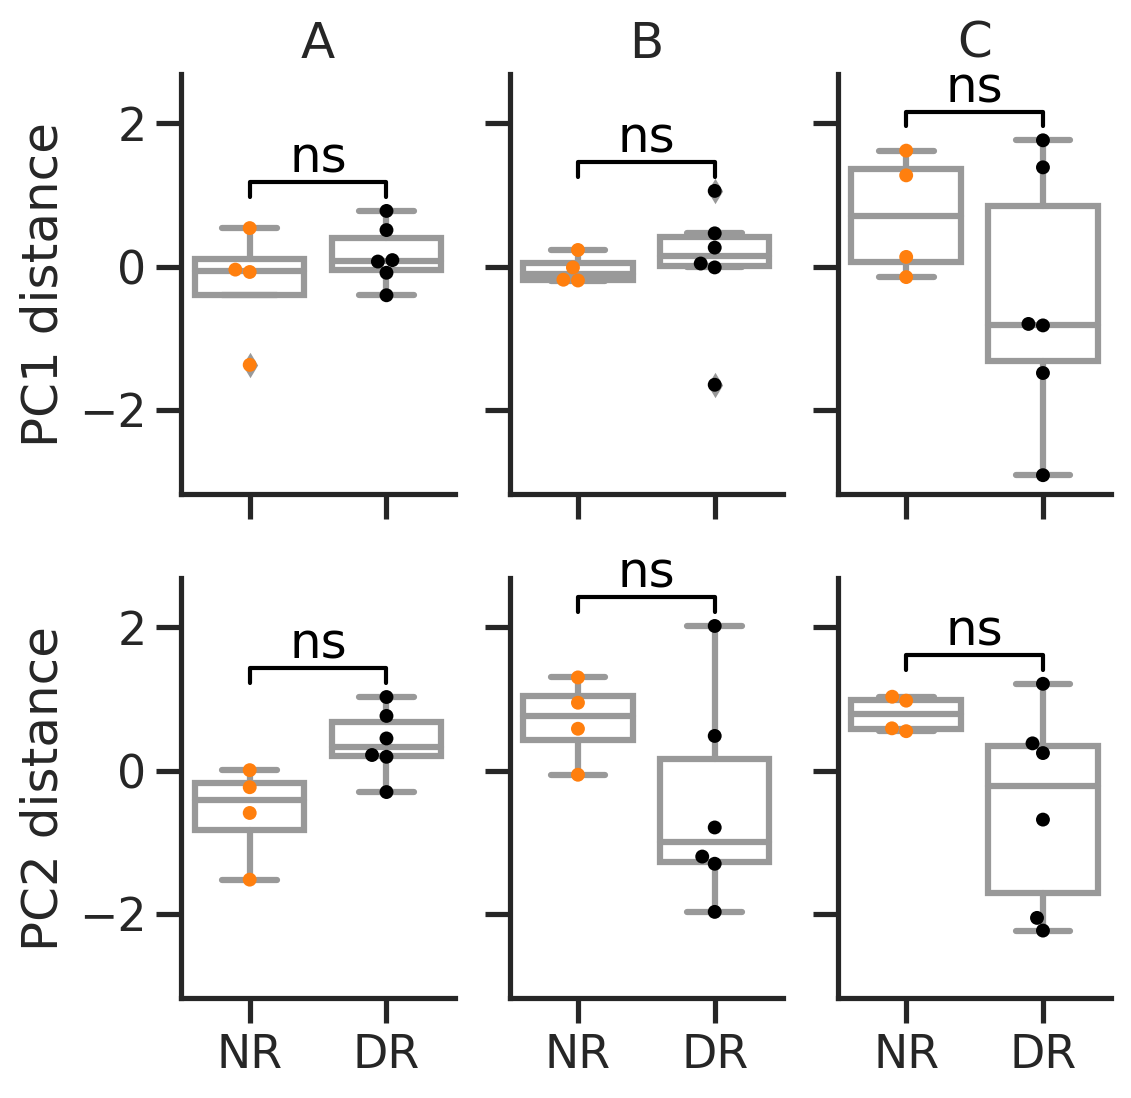

In [41]:
fig, axs = plt.subplots(2,3,figsize=(3*2,2*3), sharex=True, sharey=True)
for i in range(6):
    ax = axs.flat[i]
    sns.boxplot([a[:,i], b[:,i]], color='white', ax=ax)
    sns.swarmplot([a[:,i], b[:,i]], palette=['C1', 'k'], ax=ax)
    ax.set_xticklabels(['NR', 'DR'])
    
        
    q = qs[i]
    # q = ps[i]
    if q > 0.05:
        mark = 'ns'
    elif q < 0.05 and q > 0.001:
        mark = '*'
    elif q < 0.001:
        mark = '***'
    
    # statistical annotation
    x1, x2 = 0, 1   
    y, h = np.hstack([a[:,i], b[:,i]]).max() + 0.2, 0.2 #1, 1
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', color='k')
    
    sns.despine(ax=ax)
    ax.grid(False)

axs[0,0].set_ylabel('PC1 distance')
axs[1,0].set_ylabel('PC2 distance')
axs[0,0].set_title('A')
axs[0,1].set_title('B')
axs[0,2].set_title('C')

# score based (ABC) soft-assignment

In [42]:
samples = ['P28_1','P28_2', 'P38_1', 'P38_2', 
           'P28_dr_1', 'P28_dr_3', 'P38_dr_1', 'P38_dr_2', 
           'P28_dl_1', 'P28_dl_2',
          ]

In [43]:
# get ABC scores
g0_a = stats.zscore(np.array(adata[:,agenes].layers['lognorm'].todense()), axis=0).mean(axis=1)
g0_b = stats.zscore(np.array(adata[:,bgenes].layers['lognorm'].todense()), axis=0).mean(axis=1)
g0_c = stats.zscore(np.array(adata[:,cgenes].layers['lognorm'].todense()), axis=0).mean(axis=1)

# g0_b = adata[:,bgenes].layers['lognorm'].mean(axis=1)
# g0_c = adata[:,cgenes].layers['lognorm'].mean(axis=1)
# g0_a = np.array(g0_a).reshape(-1,)
# g0_b = np.array(g0_b).reshape(-1,)
# g0_c = np.array(g0_c).reshape(-1,)

# make ABC scores comparable and norm to [0,1] [40% to 95%]
vmin_p, vmax_p = 40, 95
vmin_a = np.percentile(g0_a, vmin_p)
vmax_a = np.percentile(g0_a, vmax_p)

vmin_b = np.percentile(g0_b, vmin_p)
vmax_b = np.percentile(g0_b, vmax_p)

vmin_c = np.percentile(g0_c, vmin_p)
vmax_c = np.percentile(g0_c, vmax_p)

g0_a = np.clip((g0_a-vmin_a)/(vmax_a-vmin_a), 0, 1)
g0_b = np.clip((g0_b-vmin_b)/(vmax_b-vmin_b), 0, 1)
g0_c = np.clip((g0_c-vmin_c)/(vmax_c-vmin_c), 0, 1)

# separate them into scale and frequency
g0_sum  = (g0_a+g0_b+g0_c)
freq0_a = g0_a/(g0_sum+1e-5)
freq0_b = g0_b/(g0_sum+1e-5)
freq0_c = g0_c/(g0_sum+1e-5)

adata.obsm['size_freq_abc'] = np.vstack([freq0_a, freq0_b, freq0_c, g0_sum]).T

In [44]:
res = []
for sample in samples: 
    if 'dr' in sample:
        cond = 'DR'
    elif 'dl' in sample:
        cond = 'DL'
    else:
        cond = 'NR'
        
    adatasub = adata[adata.obs['biosample']==sample]
    freq_a = adatasub.obsm['size_freq_abc'][:,0]
    freq_b = adatasub.obsm['size_freq_abc'][:,1]
    freq_c = adatasub.obsm['size_freq_abc'][:,2]
    
    n = len(adatasub)
    
    cond_na = (freq_a+freq_b+freq_c)<1e-1
    tn = np.sum(cond_na)
    
    rank = np.argsort(np.vstack([freq_a,freq_b,freq_c]).T[~cond_na], axis=1)[:,-1]
    ta = np.sum(rank==0)
    tb = np.sum(rank==1)
    tc = np.sum(rank==2)
    
    assert np.abs(n-(ta+tb+tc)-tn) < 1e-1
    res.append([sample, cond, ta/n*100, tb/n*100, tc/n*100, tn/n*100])
    
res = pd.DataFrame(res, columns=['sample', 'cond', 'A', 'B', 'C', 'N']).set_index('sample')
res

,cond,A,B,C,N
sample,,,,,
P28_1,NR,22.501207,40.753259,36.648962,0.096572
P28_2,NR,28.484541,39.077547,32.184491,0.253421
P38_1,NR,19.166667,40.555556,39.583333,0.694444
P38_2,NR,31.259484,34.749621,33.737987,0.252908
P28_dr_1,DR,53.804078,18.249627,27.846842,0.099453
P28_dr_3,DR,47.530635,25.584850,26.550316,0.334200
P38_dr_1,DR,37.262984,31.904369,30.420445,0.412201
P38_dr_2,DR,32.968237,33.588901,33.260314,0.182548
P28_dl_1,DL,30.207013,43.852978,25.940008,0.000000


saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/241209/type_abc_change_bars_2024-12-09.pdf


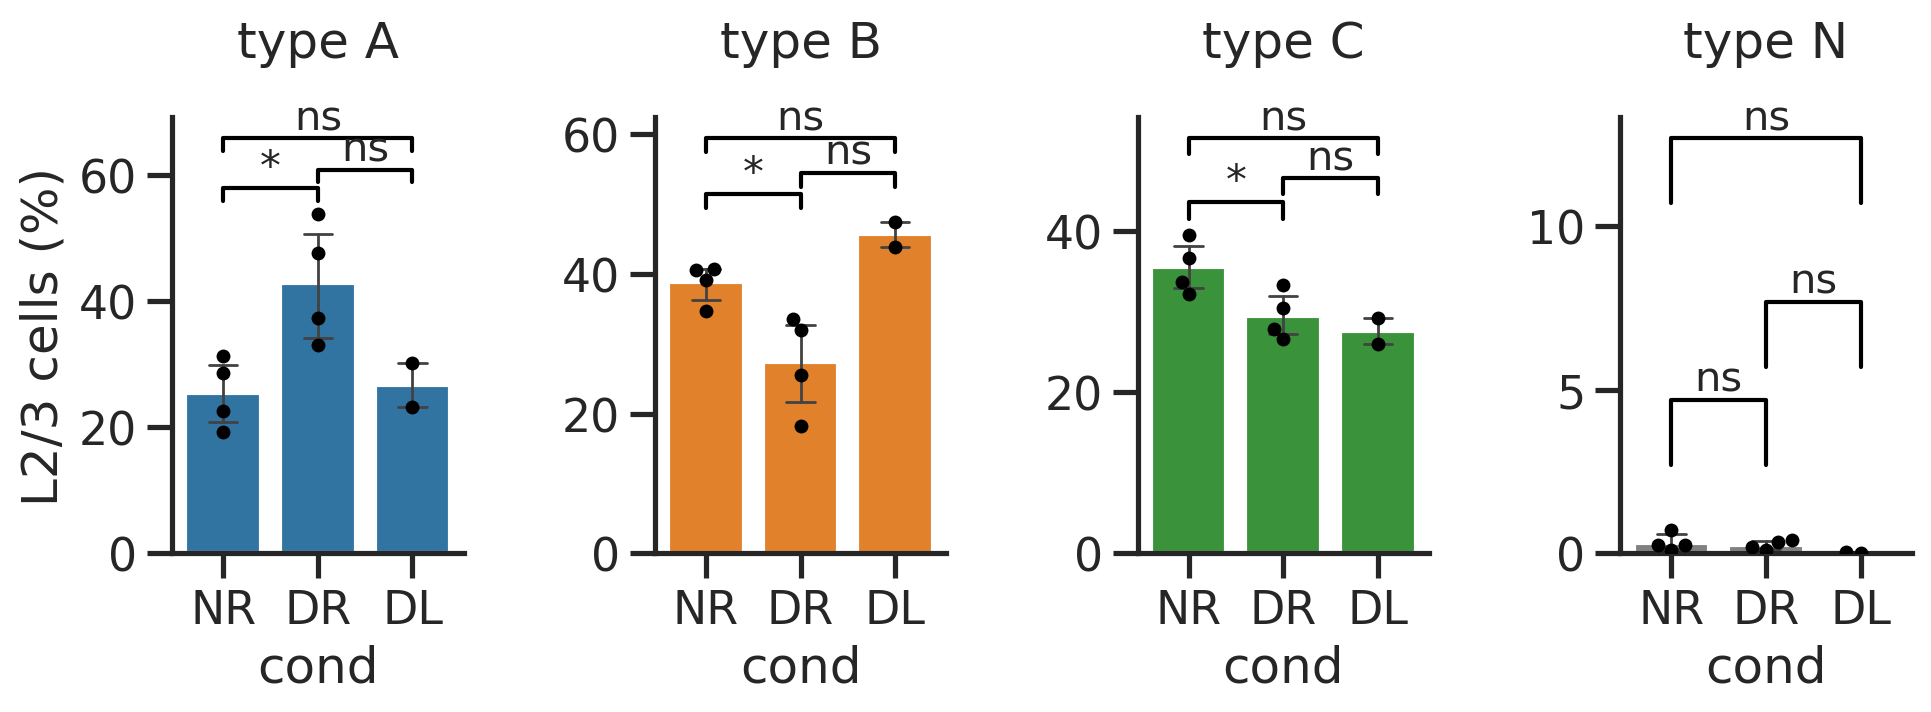

In [45]:
fig, axs = plt.subplots(1, 4, figsize=(2*5,4))
unq_lbls = ['A', 'B', 'C', 'N']
unq_colors = ['C0', 'C1', 'C2', 'gray']

allps = []
allps2 = []
allps3 = []
for ax, col, color in zip(axs, unq_lbls, unq_colors):
    sns.barplot(data=res, x='cond', y=col, ax=ax, color=color, capsize=0.3, errwidth=1)
    sns.swarmplot(data=res, x='cond', y=col, color='k', ax=ax, )
    ax.set_title(f'type {col}', y=1.1)
    sns.despine(ax=ax)
    ax.grid(False)
    ax.set_ylabel('')
    
    a = res[res['cond']=='NR'][col]
    b = res[res['cond']=='DR'][col]
    c = res[res['cond']=='DL'][col]
    
    s, p = stats.ttest_ind(a, b)
    s, p2 = stats.ttest_ind(a, c)
    s, p3 = stats.ttest_ind(b, c)
    
    allps.append(p)
    allps2.append(p2)
    allps3.append(p3)
    
rej, allqs, _, _ = multipletests(allps, method='fdr_bh')
rej, allqs2, _, _ = multipletests(allps2, method='fdr_bh')
rej, allqs3, _, _ = multipletests(allps3, method='fdr_bh')

for ax, col, color, q in zip(axs, unq_lbls, unq_colors, allqs):
    mark = p_mark(q)
    # statistical annotation
    x1, x2 = 0, 1   
    y, h = res[col].max() + 2, 2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', fontsize=15)
    
for ax, col, color, q in zip(axs, unq_lbls, unq_colors, allqs2):
    mark = p_mark(q)
    # statistical annotation
    x1, x2 = 0, 2   
    y, h = res[col].max() + 10, 2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', fontsize=15)
    
for ax, col, color, q in zip(axs, unq_lbls, unq_colors, allqs3):
    mark = p_mark(q)
    # statistical annotation
    x1, x2 = 1, 2   
    y, h = res[col].max() + 5, 2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', fontsize=15)
    
axs[0].set_ylabel('L2/3 cells (%)')
fig.tight_layout()
output = os.path.join(outfigdir, "type_abc_change_bars.pdf")
powerplots.savefig_autodate(fig, output)
plt.show()

In [46]:
allqs, allps

(array([0.04491779, 0.04491779, 0.0458198 , 0.66354152]),
 [0.018744596267879842,
  0.022458893461125538,
  0.034364850519881404,
  0.6635415191031726])

# save this

In [47]:
# f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes_july8_2024.csv"
# res_qry.to_csv(f, header=True, index=True)

# Quantify JS distance v2 (NR DR only)

In [48]:
from scipy.spatial.distance import jensenshannon
from scipy.cluster import hierarchy as sch

In [49]:
# labels
labels3 = labels
dfs3 = [adata_dict[lbl].obs for lbl in labels3]
print(labels3)

['P28NR', 'P38NR', 'P28DR', 'P38DR', 'P28DL']


In [50]:
bins = np.arange(-15, 15+2, 1)
hists3 = []
for df in dfs3:
    a, _, _ = np.histogram2d(df['PC1'], df['PC2'], bins=bins)
    a = a/np.sum(a)*100
    hists3.append(a)

In [51]:
num = len(labels3)
res_js3 = np.zeros((num,num))
js_min = 1
for i in np.arange(num):
    for j in np.arange(num):
        if j > i:
            p = np.ravel(hists3[i])
            q = np.ravel(hists3[j])
            p = p/np.sum(p)
            q = q/np.sum(q)
            js = jensenshannon(p, q) 
            
            res_js3[i,j] = js
            res_js3[j,i] = js
            js_min = min(js, js_min)

In [52]:
# order = [2,0,3,1,4]
order3, Z3 = basicu.order_by_hc(res_js3, return_Z=True) # [::-1]
# np.array(labels)[order]

/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py:437: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(X, method=method, metric=metric)


In [53]:
js_min

0.22344018189811987

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/241209/js_heatmap_nrdr_only_2024-12-09.pdf


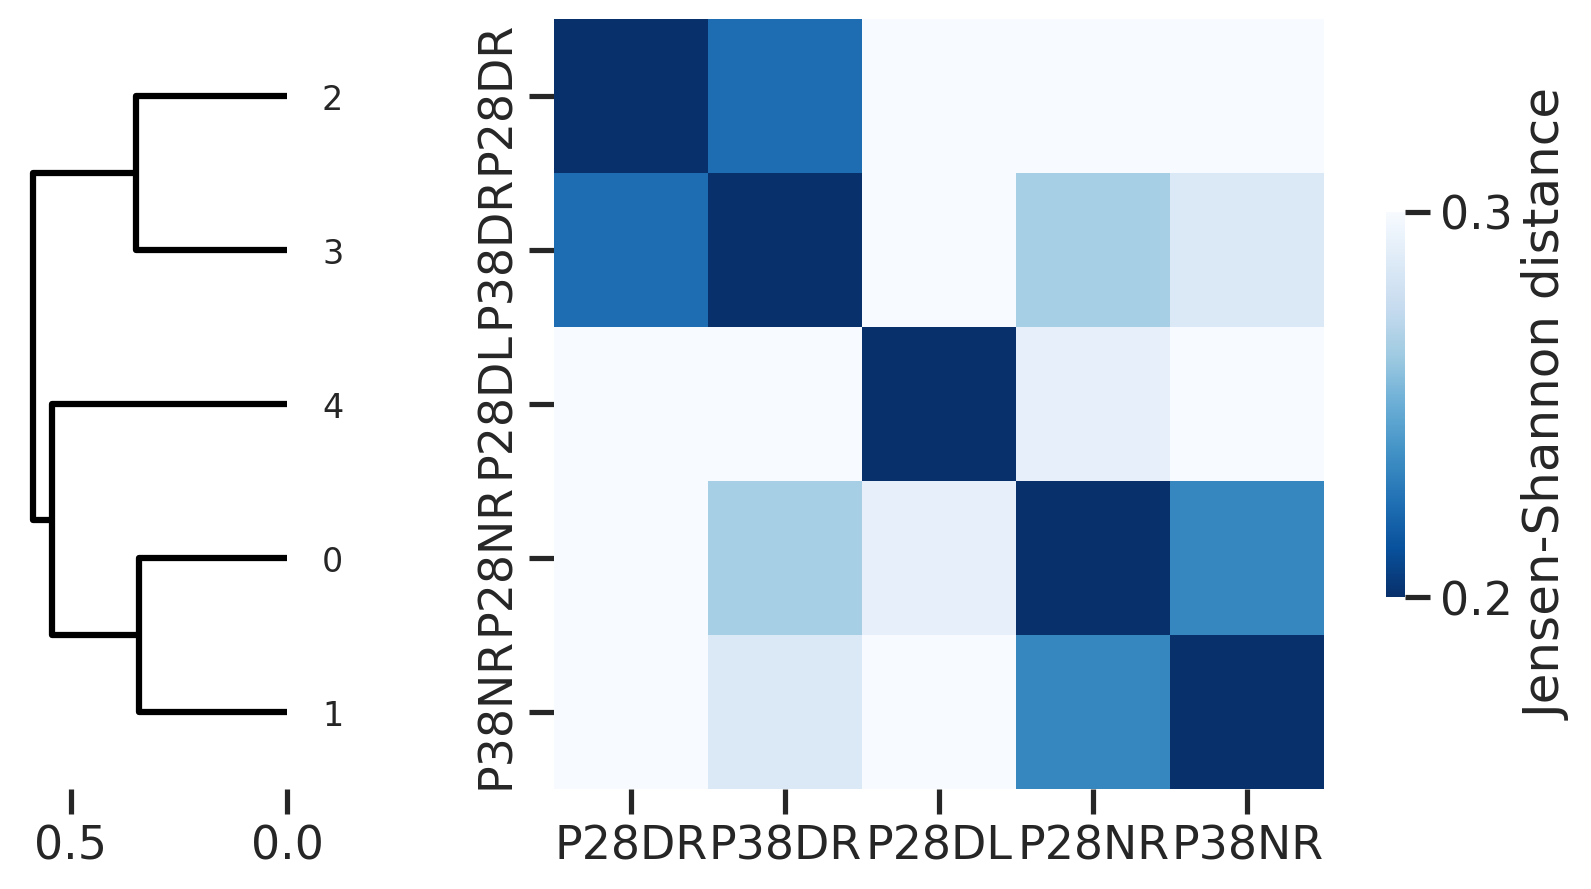

In [54]:
fig, axs = plt.subplot_mosaic("ABBBB", figsize=(10,5))

ax = axs['A']
d = sch.dendrogram(Z3, ax=ax, orientation='left', above_threshold_color='k', color_threshold=0)
sns.despine(ax=ax, left=True, bottom=True)
ax.invert_yaxis()
ax.grid(False)

ax = axs['B']
sns.heatmap(pd.DataFrame(res_js3).reindex(order3)[order3], cmap='Blues_r', 
            # vmin=js_min, vmax=0.4,
            # vmin=js_min,
            vmin=0.2,
            vmax=0.3,
            cbar_kws=dict(shrink=0.5, ticks=[0.2, 0.3], label='Jensen-Shannon distance'),
            xticklabels=np.array(labels3)[order3],
            yticklabels=np.array(labels3)[order3],
            ax=ax,
           )
ax.set_aspect('equal')
output = os.path.join(outfigdir, "js_heatmap_nrdr_only.pdf")
powerplots.savefig_autodate(fig, output)